# Montserrat event selector for Machine Learning
The aim of this code is to find the best N events of each type, and create a corresponding CSV file and data structure for entry into Alexis' and Marielle's AAA codes.

In [ ]:
#!/usr/bin/env pythong 
import os
from glob import glob
import pandas as pd
import numpy as np
from obspy.core import read
import sys
from statsmodels.stats.weightstats import DescrStatsW

LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import mulplt
from modutils import yn_choice


"""
#%matplotlib widget
%matplotlib inline

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

np.set_printoptions(linewidth=160)
"""

def read_volcano_def():
    filepath = './volcano_def.csv'
    subclass_df = pd.read_csv(filepath)
    subclass_df.columns = subclass_df.columns.str.lstrip()
    return subclass_df
    
def build_master_event_catalog(csvdir, seisandbname, catalogfile, subclasses_for_ML, max_duration = 60):
    # load all the year/month CSV files
    csvfiles = glob(os.path.join(csvdir, 'reawav_%s??????.csv' % seisandbname))
    frames = []
    for csvfile in csvfiles:
        df = pd.read_csv(csvfile)
        frames.append(df) 
    dfall = pd.concat(frames, sort=True)
    dfall.set_index('filetime', inplace=True) # we will need this later to remerge
    dfall.sort_index(inplace=True)
    """
    for index, row in dfall.iterrows():
        
        # For simplicity, copy 'D' and 'R' mainclass to subclass
        if row['mainclass'] in ['D', 'R']: # Do I need L here too?
            dfall.loc[index, 'subclass']=row['mainclass']
    """ 
    # replace loop above
    for mainclass in ['R', 'D']:
        dfall.loc[dfall['mainclass'] == mainclass, 'subclass'] = mainclass
    
    # Drop the mainclass column, as it is now superfluous.
    dfall.drop(columns=['mainclass'], inplace=True)
    
    # Add an etype column
    #dfall['etype'] = dfall['subclass'].replace(subclasses, etypes)
    
    # Add columns to assign a percentage for each subclass
    for subclass in subclasses_for_ML:
        dfall[subclass] = 0
    
    # But set column for actual subclass to 100%  
    """
    for index, row in dfall.iterrows():            
        # Set dfall['h'] to 100 if dfall['subclass']=='h', etc
        dfall.loc[index, row['subclass']] = 100        
    """
    # replace row operations above
    for subclass in subclasses_for_ML:
        dfall.loc[dfall['subclass'] == subclass, subclass] = 100
        
    # Add a new_subclass column
    dfall['new_subclass'] = dfall['subclass']

    # Add weight column. I will give really clear events higher weight when I process them
    dfall['weight']=3 # weight for events I have not visually checked
    
    # Add column that records if event is checked
    dfall['checked']=False
    
    # Add column that records if event is marked for splitting
    dfall['split']=False    
    
    # Add column that records if event is marked for deletion
    dfall['delete']=False
    
    # Add column that records if event should be ignored
    # Ignore any events longer than 1-minute, as they are likely to contain multiple events 
    # or just be unhelpful for classifying short signals which are more common
    dfall['ignore'] = dfall['twin']>max_duration
    
    # Now we have a catalog dataframe we can work with. Let's save this.
    dfall.to_csv(catalogfile)
    
    return dfall

def _count_by_subclass(df):
    checked = df[df['checked']==True]
    unchecked = df[df['checked']==False]
    
    print('Event counts:')
    
    if len(checked.index)>0:
        print('Checked events: %d' % len(checked.index) )
        checked_by_subclass = checked.groupby("new_subclass")
        print(checked_by_subclass['path'].count())
        
    if len(unchecked.index)>0:
        print('Unchecked events: %d' % len(unchecked.index) )
        unchecked_by_subclass = unchecked.groupby("new_subclass")
        print(unchecked_by_subclass['path'].count()) 

    print('Events by weight / quality threshold')
    print(df.groupby('weight')['path'].count())

        

def _select_best_events(df, allowed_subclasses, N=100, exclude_checked=True):
    # When we are iterating, we want to exclude the checked events, else we are repeating our work.
    # When we return our final list, we do not want to exclude checked events
    all_subclasses = df['new_subclass'].unique()
    best_events_dict = {}
    for subclass in all_subclasses:
        if subclass in allowed_subclasses:
            #print('\nProcessing subclass=%s' % subclass)
            is_subclass =  df['new_subclass']==subclass
            df_subclass = df[is_subclass]
            
            # mechanism to weight out checked events
            df_subclass['include'] = 1 - df_subclass['ignore']
            if exclude_checked:
                print('Excluding checked events')
                df_subclass['include'] = df_subclass['include'] * (1 - df_subclass['checked'])
            
            if len(df_subclass.index)>0:
                # we use three criteria for ranking events. detection_quality has the largest magnitude, but can be missing, so we also add snr, 
                # and finally quality as a tie-braker, since it has a small range for events that have made it this far
                df_subclass['sortcol'] = df_subclass['quality'] # always present
                if 'snr' in df_subclass.columns:
                    df_subclass['sortcol'] = df_subclass['sortcol'] + df_subclass['snr']
                if 'detection_quality' in df_subclass.columns:
                    df_subclass['sortcol'] = df_subclass['sortcol'] + df_subclass['detection_quality']                    
                df_subclass['sortcol'] = df_subclass['sortcol'] * df_subclass['weight'] * df_subclass['include']
                df_subclass.drop(columns=['include'], inplace=True)

                L = len(df_subclass.index)
                H = int(min([L, N]))
                print('Selecting %d events of type %s from a total of %d' % (H, subclass, L))
                df_subclass.sort_values(by=['sortcol'], ascending=False, inplace=True)
                df_subclass.drop(columns=['sortcol'], inplace=True)
                df_subclass = df_subclass.head(H)
                best_events_dict[subclass]=df_subclass

    return best_events_dict 

def get_weighted_fingerprints(dfall, subclasses_for_ML, N=300, exclude_checked=False):

    fingerprints = {}
    best_events_dict = _select_best_events(dfall, subclasses_for_ML, N=N, exclude_checked=exclude_checked)
    for subclass in subclasses_for_ML:
        if subclass in best_events_dict.keys(): 
            print('Computing fingerprint for subclass ',subclass)
            thisdf = best_events_dict[subclass]
            if len(thisdf.index)>30:
                statsdf = pd.DataFrame()
                statsdf['statistic'] = ['mean', 'std', '25%', '50%', '75%']
                statsdf.set_index(['statistic'], inplace = True)

                for col in [ 'peaktime', 'kurtosis', 'medianF', 'peakF', 'bw_min', 'bw_max', 'band_ratio']:
                    # compute mean, std, median, 25% percentile, 75% percentile
                    wdf = DescrStatsW(thisdf[col], weights=thisdf['weight'].astype(float)*thisdf[subclass].astype(float), ddof=1)
                    p = [0.25,0.50,0.75]
                    q  = wdf.quantile(p) 
                    statsdf.loc['mean', col] = wdf.mean
                    statsdf.loc['std', col] = wdf.std
                    statsdf.loc['50%', col] = q[p[1]]
                    statsdf.loc['25%', col] = q[p[0]]
                    statsdf.loc['75%', col] = q[p[2]]

                fingerprints[subclass] = statsdf
                #print(fingerprints[subclass])
    return fingerprints    

def get_fingerprints(dfall, allowed_subclasses, N=300, exclude_checked=True):
    """
    All we do right now is a dataframe describe, so we return the stats of each column.
    
    wdf = DescrStatsW(df.x, weights=df.wt, ddof=1) 
    
    """
    #df = best_events_dict.groupby("subclass")
    fingerprints = {}
    best_events_dict = _select_best_events(dfall, allowed_subclasses, N=N, exclude_checked=exclude_checked)
    for subclass in allowed_subclasses:
        if subclass in best_events_dict.keys(): 
            print('Computing fingerprint for subclass ',subclass)
            #df_subclass = df.get_group(subclass)
            df_subclass = best_events_dict[subclass]     
            fingerprints[subclass] = df_subclass[[ 'peaktime', 
                'kurtosis', 'medianF', 'peakF', 'bw_min', 'bw_max', 'band_ratio']].describe()
            #print(fingerprints[subclass])
    return fingerprints

def save_fingerprints(fingerprints, allowed_subclasses):
    for subclass in allowed_subclasses:
        if subclass in fingerprints.keys(): 
            fingerprints[subclass].to_csv('fingerprint_%s.csv' % subclass)
  
def _merge_dataframes(df_dict, accepted_subclasses):
    frames = []
    for subclass in accepted_subclasses:
        if subclass in df_dict.keys():
            frames.append(df_dict[subclass]) 
    return pd.concat(frames, sort=True)     

def _guess_subclass(row, fingerprints, subclasses_for_ML):
    chance_of = {}
    for item in subclasses_for_ML:
        chance_of[item]=0.0
    
    params = ['peaktime', 'kurtosis', 'medianF', 'peakF', 'bw_min', 'bw_max', 'band_ratio']
    for subclass in fingerprints.keys():
        fingerprint = fingerprints[subclass]
        #fingerprint.reset_index(inplace=True)
        #print(fingerprint.columns)
        for param in params:
            thisval = row[param]
            
            # test against mean+/-std
            meanval = fingerprint[param]['mean']
            stdval = fingerprint[param]['std']
            minus1sigma = meanval - stdval
            plus1sigma = meanval + stdval
            
            if thisval > minus1sigma and thisval < plus1sigma:
                weight = 1.0 - abs(thisval-meanval)/stdval
                chance_of[subclass] += weight
                
            # test against 25-75% percentile
            medianval = fingerprint[param]['50%']
            val25 = fingerprint[param]['25%']
            val75 = fingerprint[param]['75%']
            if thisval > val25 and thisval < val75:
                if thisval < medianval:
                    weight = 1.0 - (medianval-thisval)/(medianval-val25)
                else:
                    weight = 1.0 - (thisval-medianval)/(val75-medianval)
                chance_of[subclass] += weight
    
    print('The event is classified as %s, but here are our guesses:' % row['subclass'])
    total = 0
    for subclass in chance_of.keys():
        total += chance_of[subclass]
    for subclass in chance_of.keys():
        if total>0:
            print('subclass: %s, points = %f, probability = %3.0f%%' % (subclass, chance_of[subclass], 100*chance_of[subclass]/total))


def qc_best_events(best_events_dict, seisan_subclasses, subclasses_for_ML, fingerprints):
    
    for subclass in subclasses_for_ML:
        #if subclass=='u' or subclass=='n': # we don't care about these events
        #    continue
        #print('Processing ',subclass)
        if subclass in best_events_dict.keys():
            df = best_events_dict[subclass]
            print('Processing %d events of type %s' % (len(df.index), subclass) )

            for index, row in df.iterrows():
                #picklepath = os.path.join(SEISAN_DATA, row.path.replace('WAV','PICKLE') + '.pickle')
                picklepath = os.path.join(SEISAN_DATA, row.path.replace('WAV','PICKLE2') + '.pickle')
                print('Loading %s' % picklepath)
                if os.path.exists(picklepath):
                    
                    st = read(picklepath) #.select(station='MBWH')
                    st.plot();
                    #mulplt(st)
                    starttime = st[0].stats.starttime + row['peaktime']-10
                    endtime = starttime + 20
                    st.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=None)
                    st.plot()
                    
                    # Hints
                    csvpath = picklepath.replace('.pickle', '.csv')
                    tracedf = pd.read_csv(csvpath)
                    print(tracedf[['id', 'peaktime', 'kurtosis', 'medianF', 'peakF','bw_min', 'bw_max', 'band_ratio', 'kurtosis', 'energy']])
                    _guess_subclass(row, fingerprints, subclasses_for_ML)
                    
                    # Input
                    checked = False
                    print('Please reclassify the event.')
                    print('Valid subclasses are: ', seisan_subclasses )
                    print('To enter percentage probabilities, e.g. 75% l, 25%h, enter l, 75, h, 25')
                    print('Optionally add a weight [0-9] too with a trailing integer, e.g. l, 75,  h, 25, 5')
                    print('Or:\n\ts = mark event for splitting')
                    print('\td = mark event for deletion')
                    print('\ti = ignore event')
                    
                    try:                       
                        new_subclass = input('\t ?') 
                        if not new_subclass:
                            new_subclass = subclass
                        if new_subclass == 's':
                              df.loc[index, 'split'] = True
                              checked = True
                        if new_subclass == 'i':
                              df.loc[index, 'ignore'] = True 
                              checked = True
                        if new_subclass == 'd':
                              df.loc[index, 'delete'] = True 
                              checked = True
                        if not checked:                         
                            if not ',' in new_subclass: # convert to a subclass, percentage string
                                new_subclass = new_subclass + ', 100'
                            spl = new_subclass.split(',') # split string to subclass probability list 
                            if len(spl) % 2 == 1:
                                df.loc[index, 'weight'] = int(spl.pop())
                            spd = {spl[a]:spl[a + 1] for a in range(0, len(spl), 2)} # subclass probability dict
                            for key in subclasses_for_ML:
                                if key in spd.keys():
                                    df.loc[index, key] = int(spd[key])
                            keymax = max(spd, key=spd.get)
                            df.loc[index, 'new_subclass']=keymax  
                            checked = True
                        if checked:
                            df.loc[index, 'checked']=True
                    except:
                        print('Input may have been faulty. Skipping event')
                        pass
                        
                    
            best_events_dict[subclass] = df
    #return _merge_dataframes(best_events_dict, best_events_dict.keys())
    return best_events_dict

def remove_marked_events(df):  
    dfsubset = df
    n_all = len(dfsubset.index)
    dfsubset = dfsubset[dfsubset['delete']==False]
    n_after_delete = len(dfsubset.index)
    dfsubset = dfsubset[dfsubset['ignore']==False]
    n_after_ignore = len(dfsubset.index)
    dfsubset = dfsubset[dfsubset['split']==False]
    n_after_split = len(dfsubset.index)
    n_delete = n_all - n_after_delete
    n_ignore = n_after_delete - n_after_ignore
    n_split = n_after_ignore - n_after_split
    print('Removed events: Marked to:')
    print('- split ', n_split)
    print('- delete ', n_delete)
    print('- ignore ', n_ignore)
    print('Catalog down from %d to %d events' % (n_all, n_after_split))
    print(' ')  
    return dfsubset

def to_AAA(df, subclasses_for_ML, outfile, ignore_extra_columns=True, make_local_archive=True):
    """
    create output file for AAA
    """ 
    print(' ')
    print('Here is the updated list of events by subclass and whether they have been checked:')
    _count_by_subclass(df)
    print(' ')    

    print('*** Choose labelled events for input to supervised machine learning. ***')
    minweight = int(input('Minimum weight (signal quality, 0-9): '))
    if minweight>0:
        df = df[df['weight']>=minweight]
    #choice = input('Include only checked events ? (y/n) ')
    if yn_choice('Include only checked events ? (y/n)', default='y'):
        print('Removing unchecked events')
        df = df[df['checked']==True]
    
    print('Now we have the following number of events by subclass:')
    L = []
    for i, subclass in enumerate(subclasses_for_ML):
        df_subclass = df[df['new_subclass']==subclass]
        L.append(len(df_subclass.index))
        print('- %s: %d' % (subclass, L[i]))
    maxnumevents = int(input('What is the maximum number of events of each subclass you want to use for supervised learning (e.g. %d) ? ' % max(L)))
    best_events_dict = _select_best_events(df, subclasses_for_ML, N=maxnumevents, exclude_checked=False)
    df = _merge_dataframes(best_events_dict, subclasses_for_ML)
    
    minnumevents = int(input('What is the minimum number of events of each subclass you want to use for supervised learning, (e.g. %d) ?\nSubclasses with less than this number of events will be removed. ' % int(max(L)/10)))
    for subclass in df['new_subclass'].unique():
        df_subclass = df[df['new_subclass']==subclass]
        if len(df_subclass.index) < minnumevents:
            print('Eliminating subclass %s' % subclass)
            subclasses_for_ML.remove(subclass)
            
    print('The subclasses for machine learning are %s. Removing other subclasses.' % ''.join(subclasses_for_ML) )
    df_list = []
    df.sort_values(by='filetime',inplace=True)
    for i, row in df.iterrows():
        row['new_subclass'] = row['new_subclass'].strip()
        if row['new_subclass'] in subclasses_for_ML:
            df_list.append(row)
    df = pd.DataFrame(df_list) 
    
    print('Here is the FINAL list of events by subclass and whether they have been checked:')
    _count_by_subclass(df)    
    
    #df.rename(columns = {'twin':'duration'}, inplace = True)
    df.rename(columns = {'twin':'length'}, inplace = True)
    #df['f0']=None
    #df['f1']=None
    df['f0']=0.5
    df['f1']=25.0   
    
    """
    confidence_threshold = int(input('What is the minimum confidence percentage (e.g. 50) you wish to use ? This should be an integer.'))
    if confidence_threshold:
        good_indices = []
        for subclass in subclasses_for_ML:
            good_indices.expand(df[subclass] >= confidence_threshold)
        df = df.iloc[good_indices]
    print(df[['filetime', 'new_subclass']])
    """
    
    # subset and rename columns for output
    if ignore_extra_columns:
        df=df[['new_subclass','year','month','day','hour','minute','second','length','path']]     
    df.rename(columns = {'new_subclass':'class'}, inplace = True)
    
    if make_local_archive:
        for i, row in df.iterrows():
            subclass = row['class']
            oldpath = row['path'].replace('./', '/Users/thompsong/DATA/MVO/')
            newpath = os.path.join(subclass,os.path.basename(oldpath))
            df.loc[i, 'path']=newpath
            if not os.path.exists(subclass):
                os.mkdir(subclass)
            print('cp %s %s' % (oldpath, newpath))
            os.system('cp %s %s' % (oldpath, newpath))
            
    
    df.to_csv(outfile)
    print('Saved to ',outfile)

In [ ]:
##############################################################################
SEISAN_DATA = os.path.join( os.getenv('HOME'),'DATA','MVO')
DB = 'MVOE_'
subclass_mapping = read_volcano_def() # subclasses allowed for classification
#print(subclass_mapping.columns)
seisan_subclasses = subclass_mapping['subclass'].values.tolist() # append('g') as needed, it is not an allowed subclass
#seisan_etypes = subclass_mapping['etype'].values.tolist()
subclasses_for_ML = ['D', 'R', 'r', 'e', 'l', 'h', 't'] # subclasses allowed for Machine Learning
outfile = 'catalog_all.csv'

if os.path.exists(outfile):
    dfall = pd.read_csv(outfile)
else:
    master_event_catalog = 'catalog_all_original.csv'
    dfall = build_master_event_catalog(SEISAN_DATA, DB, master_event_catalog, subclasses_for_ML)

iterate_again = False # changed this back to do the loop
while iterate_again:
    
    # how many events of each type do we want?
    _count_by_subclass(dfall)
    choice = input('How many (more) events of each subclass do you want to reclassify ? ')
    N = int(choice)

    # get/update the fingerprints of each event class
    #fingerprints = get_fingerprints(dfall, SUBCLASSES, N=300, exclude_checked=False)  
    fingerprints = get_weighted_fingerprints(dfall, subclasses_for_ML, N=300, exclude_checked=False)
    save_fingerprints(fingerprints, subclasses_for_ML)

    # for further classification select best unchecked events of each subclass based on quality_index
    best_events_dict = _select_best_events(dfall, subclasses_for_ML, N=N, exclude_checked=True)
    
    # manually QC the data
    best_events_dict = qc_best_events(best_events_dict, seisan_subclasses, subclasses_for_ML, fingerprints)
    
    # save and summarize the data
    allbest = _merge_dataframes(best_events_dict, best_events_dict.keys())
    allbest.sort_index(inplace=True)
    dfall.sort_index(inplace=True)
    dfall.update(allbest)    
    dfall.to_csv(outfile)
    _count_by_subclass(dfall)
    
    choice = input('Do you want to iterate again (y/n)?')
    if choice[0]=='n':
        iterate_again=False
 
# remove events we marked for deletion, splitting or to ignore
dfsubset = remove_marked_events(dfall)

aaa_infile = 'aaa_labelled_events.csv' 
to_AAA(dfsubset, subclasses_for_ML, aaa_infile, make_local_archive=True)

In [ ]:
# Here we plot the first 1-minute of each selected event file, padding if needed
# We do this mainly to see the variable onset time of signals within event files
import pandas as pd
aaa_infile = 'aaa_labelled_events.csv' 
dfAAA = pd.read_csv(aaa_infile)
for i, row in dfAAA.iterrows():
    st = read(row['path'])
    st = st.select(station='MBLG', component='Z')
    if len(st):
        stime = st[0].stats.starttime
        st.trim(starttime=stime,endtime=stime+60,pad=True,fill_value=0)
        st.plot();
        print('subclass = %s' % row['class'])
        #dummy = input('ENTER to see next signal')

          network: MV
          station: MBRY
         location: 
          channel: SHZ
        starttime: 1901-03-06T21:13:28.040000Z
          endtime: 1901-03-06T21:14:51.814438Z
    sampling_rate: 75.19
            delta: 0.013299640909695438
             npts: 6300
            calib: 1.0
          _format: PICKLE
        bandratio: [{'freqlims': [1.0, 6.0, 11.0], 'RSAM_high': 356.37375345385612, 'RSAM_low': 1674.4818809191802, 'RSAM_ratio': -2.23225177220937}, {'freqlims': [0.8, 4.0, 16.0], 'RSAM_high': 901.94302566710667, 'RSAM_low': 1296.1985240227809, 'RSAM_ratio': -0.52317848769960762}]
           filter: AttribDict({'freqmin': 0.5, 'freqmax': 30.0, 'zerophase': False})
          history: ['MSEED metrics computed (similar to ISPAQ/MUSTANG).', 'longest flat sequence found: 2 samples', 'padded', 'detrended', 'tapered', 'bandpass', 'unpadded', 'Signal to noise measured and added to tr.stats.metrics.', 'scipy.stats metrics added to tr.stats.metrics.', 'ampengfft']
          metri

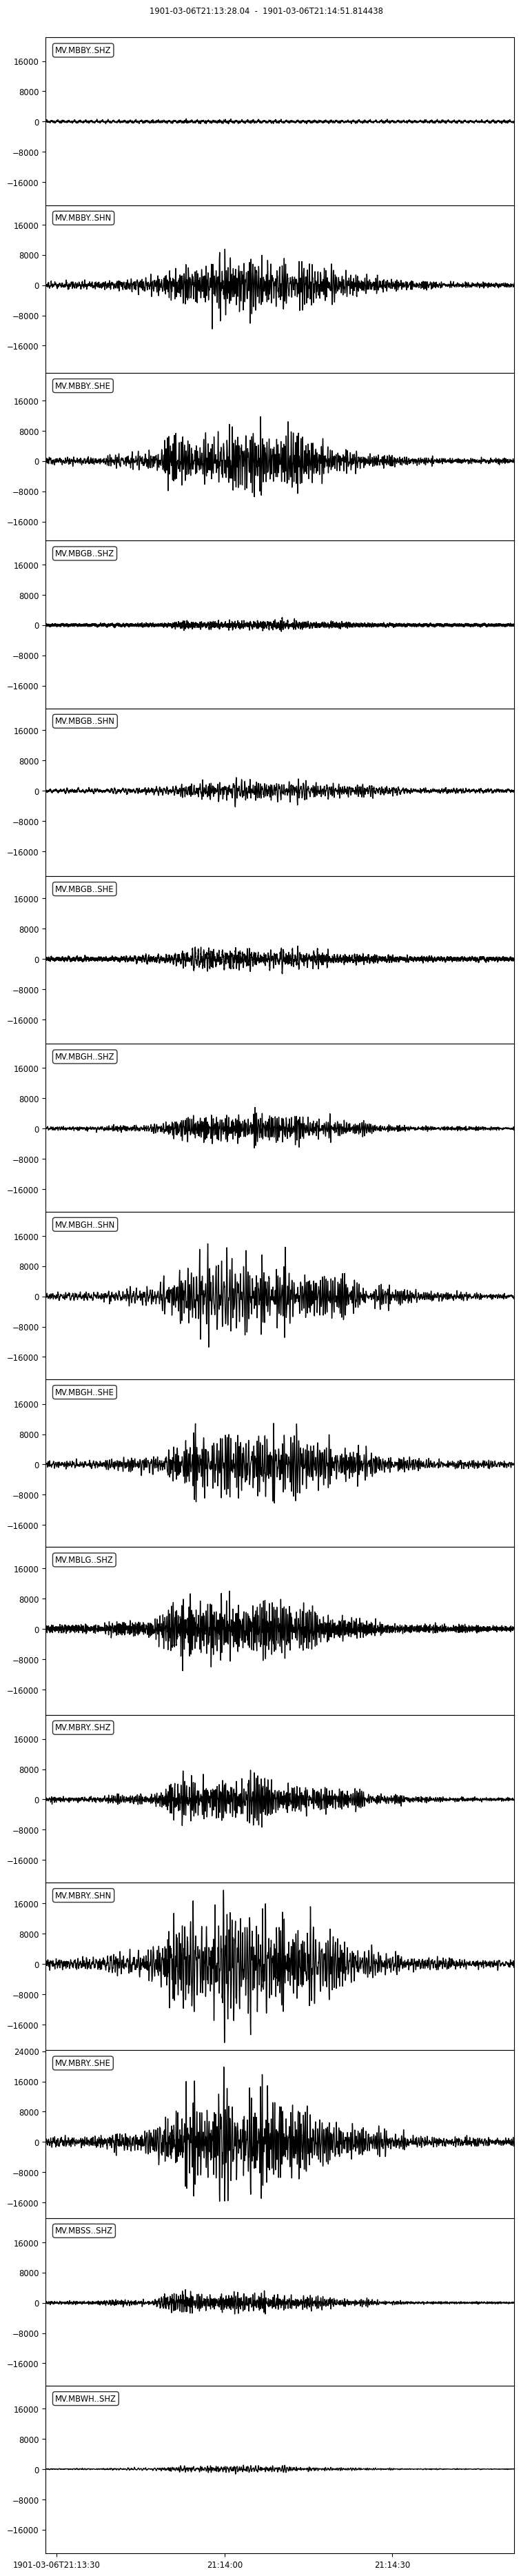

In [ ]:
# See if Pickle files are corrected
import matplotlib.pyplot as plt
import pandas as pd
from obspy.core import read, UTCDateTime
outfile = 'catalog_all.csv'
dfall = pd.read_csv(outfile)
df = dfall.copy()
df.sort_values(by=['trigger_duration'],ascending=False)
for i,row in df.iterrows():
    abpath =row['path'].replace('./WAV', '/Users/thompsong/DATA/MVO/PICKLE') + '.pickle'
    st = read(abpath)
    for tr in st:
        print(tr.stats)
    st.plot()
    dummy = input('ENTER to see next event, or q to quit')  
    if dummy=='q':
        break    

r
             twin  trigger_duration
count   26.000000         26.000000
mean   104.814854         55.432714
std     49.532632         51.301810
min     55.858492         17.728421
25%     65.500000         22.467927
50%     93.381234         31.320007
75%    120.694241         63.772443
max    249.368267        236.308020


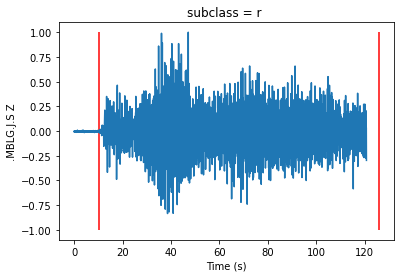

ENTER to see next event, or q to quit


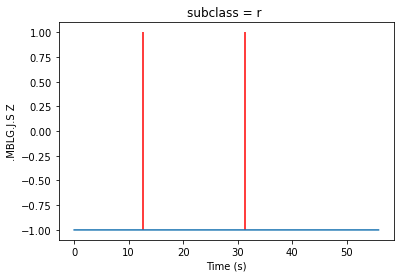

KeyboardInterrupt: Interrupted by user

In [25]:
# See if there is a relationship between detection window length and length of file for different subclasses
import matplotlib.pyplot as plt
import pandas as pd
from obspy.core import read, UTCDateTime
outfile = 'catalog_all.csv'
dfall = pd.read_csv(outfile)
df = dfall.copy()
for subclass in ['r','e','l','h','t']:
    df0 = df[df['new_subclass']==subclass]
    df0 = df0[df0['trigger_duration']>0]
    #print(df_subclass.columns)
    print(subclass)
    print(df0[['twin','trigger_duration']].describe())
    for i,row in df0.iterrows():
        abpath =row['path'].replace('./', '/Users/thompsong/DATA/MVO/')
        st = read(abpath)
        st = st.select(station='MBLG', component='Z')
        
        if len(st)==0:
            st = st.select(station='MBWH', component='Z')
        if len(st)==0:
            tr = st[0]
            st = Stream()
            st.append(tr)
        #st.plot(equal_scale=False)
        st.normalize()
        plt.plot(st[0].times(), st[0].data)
        ontime = UTCDateTime.strptime(row['ontime'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        offtime = UTCDateTime.strptime(row['offtime'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        filetime = UTCDateTime.strptime(row['filetime'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        plt.vlines([ontime-filetime, offtime-filetime],-1,1,'r')
        plt.ylabel(st[0].id)
        plt.title('subclass = %s ' % subclass)
        plt.xlabel('Time (s)')
        
        plt.show()
        dummy = input('ENTER to see next event, or q to quit')  
        if dummy=='q':
            break

In [ ]:
# See the events that I have marked for splitting
outfile = 'catalog_all.csv'
dfall = pd.read_csv(outfile)
df = dfall.copy()
df = df[df['split']==True]


